# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Tue Jun  3 13:50:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8             17W /   80W |     952MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [ ]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model_mse",
    checkpoints_dir="../checkpoints/standard_model_mse",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    discriminator_update_freq=1
)

Epoha 1/150: 100%|██████████| 115/115 [00:35<00:00,  3.21it/s, D_A=0.3723, D_B=0.4195, G=2.7262]


Epoha 1/150 - Train gubici: G: 8.7091, D_A: 0.4453, D_B: 0.5300 | Val gubici: G: 2.5212, Cycle: 1.5344
Novi najbolji validacijski cycle gubitak: 1.5344, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.5212, spremam modele...


Epoha 2/150: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s, D_A=0.2061, D_B=0.2079, G=2.1213]


Epoha 2/150 - Train gubici: G: 2.5487, D_A: 0.2473, D_B: 0.2086 | Val gubici: G: 1.7647, Cycle: 1.1234
Novi najbolji validacijski cycle gubitak: 1.1234, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.7647, spremam modele...


Epoha 3/150: 100%|██████████| 115/115 [00:31<00:00,  3.61it/s, D_A=0.2046, D_B=0.3026, G=2.5030]


Epoha 3/150 - Train gubici: G: 2.0618, D_A: 0.2555, D_B: 0.2318 | Val gubici: G: 2.0755, Cycle: 1.1359


Epoha 4/150: 100%|██████████| 115/115 [00:31<00:00,  3.70it/s, D_A=0.2521, D_B=0.2352, G=1.6452]


Epoha 4/150 - Train gubici: G: 1.9197, D_A: 0.2518, D_B: 0.2479 | Val gubici: G: 1.5985, Cycle: 1.0267
Novi najbolji validacijski cycle gubitak: 1.0267, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.5985, spremam modele...


Epoha 5/150: 100%|██████████| 115/115 [00:31<00:00,  3.70it/s, D_A=0.2893, D_B=0.3103, G=1.7957]


Epoha 5/150 - Train gubici: G: 1.8264, D_A: 0.2529, D_B: 0.2482 | Val gubici: G: 1.6319, Cycle: 0.9697
Novi najbolji validacijski cycle gubitak: 0.9697, spremam modele...


Epoha 6/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2628, D_B=0.2685, G=1.4976]


Epoha 6/150 - Train gubici: G: 1.7942, D_A: 0.2720, D_B: 0.2488 | Val gubici: G: 1.4454, Cycle: 0.7439
Novi najbolji validacijski cycle gubitak: 0.7439, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.4454, spremam modele...


Epoha 7/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2114, D_B=0.1811, G=1.4200]


Epoha 7/150 - Train gubici: G: 1.6880, D_A: 0.2492, D_B: 0.2403 | Val gubici: G: 1.2725, Cycle: 0.7680
Novi najbolji validacijski GAN gubitak: 1.2725, spremam modele...


Epoha 8/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2212, D_B=0.2551, G=1.6400]


Epoha 8/150 - Train gubici: G: 1.6559, D_A: 0.2493, D_B: 0.2387 | Val gubici: G: 1.4952, Cycle: 0.8071


Epoha 9/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2544, D_B=0.1336, G=1.4747]


Epoha 9/150 - Train gubici: G: 1.6303, D_A: 0.2490, D_B: 0.2412 | Val gubici: G: 1.7688, Cycle: 0.9034


Epoha 10/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2054, D_B=0.3339, G=1.6781]


Epoha 10/150 - Train gubici: G: 1.6148, D_A: 0.2596, D_B: 0.2351 | Val gubici: G: 1.6350, Cycle: 0.8455


Epoha 11/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2143, D_B=0.1745, G=1.5357]


Epoha 11/150 - Train gubici: G: 1.6004, D_A: 0.2575, D_B: 0.2323 | Val gubici: G: 1.3373, Cycle: 0.7946


Epoha 12/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2452, D_B=0.2549, G=1.5744]


Epoha 12/150 - Train gubici: G: 1.5307, D_A: 0.2449, D_B: 0.2372 | Val gubici: G: 1.1952, Cycle: 0.7622
Novi najbolji validacijski GAN gubitak: 1.1952, spremam modele...


Epoha 13/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2560, D_B=0.2453, G=1.3512]


Epoha 13/150 - Train gubici: G: 1.5164, D_A: 0.2556, D_B: 0.2389 | Val gubici: G: 1.5103, Cycle: 0.7254
Novi najbolji validacijski cycle gubitak: 0.7254, spremam modele...


Epoha 14/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2014, D_B=0.2248, G=1.7511]


Epoha 14/150 - Train gubici: G: 1.4815, D_A: 0.2539, D_B: 0.2371 | Val gubici: G: 1.2003, Cycle: 0.9125


Epoha 15/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2472, D_B=0.2429, G=1.4239]


Epoha 15/150 - Train gubici: G: 1.4771, D_A: 0.2558, D_B: 0.2334 | Val gubici: G: 1.1578, Cycle: 0.7087
Novi najbolji validacijski cycle gubitak: 0.7087, spremam modele...
Novi najbolji validacijski GAN gubitak: 1.1578, spremam modele...


Epoha 16/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2445, D_B=0.2405, G=1.2527]


Epoha 16/150 - Train gubici: G: 1.4692, D_A: 0.2539, D_B: 0.2319 | Val gubici: G: 1.5247, Cycle: 0.6923
Novi najbolji validacijski cycle gubitak: 0.6923, spremam modele...


Epoha 17/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2587, D_B=0.3734, G=1.1547]


Epoha 17/150 - Train gubici: G: 1.4720, D_A: 0.2568, D_B: 0.2309 | Val gubici: G: 2.1166, Cycle: 0.6885
Novi najbolji validacijski cycle gubitak: 0.6885, spremam modele...


Epoha 18/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2493, D_B=0.2162, G=1.2966]


Epoha 18/150 - Train gubici: G: 1.4531, D_A: 0.2601, D_B: 0.2359 | Val gubici: G: 1.4523, Cycle: 0.7070


Epoha 19/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2311, D_B=0.3438, G=1.3971]


Epoha 19/150 - Train gubici: G: 1.4856, D_A: 0.2523, D_B: 0.2287 | Val gubici: G: 1.8011, Cycle: 0.7035


Epoha 20/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.3555, D_B=0.1851, G=1.2235]


Epoha 20/150 - Train gubici: G: 1.4496, D_A: 0.2528, D_B: 0.2187 | Val gubici: G: 1.8775, Cycle: 0.6156
Novi najbolji validacijski cycle gubitak: 0.6156, spremam modele...


Epoha 21/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2280, D_B=0.1085, G=1.9413]


Epoha 21/150 - Train gubici: G: 1.4886, D_A: 0.2761, D_B: 0.2185 | Val gubici: G: 1.4496, Cycle: 0.6755


Epoha 22/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2293, D_B=0.2268, G=1.4672]


Epoha 22/150 - Train gubici: G: 1.3918, D_A: 0.2455, D_B: 0.2218 | Val gubici: G: 1.1433, Cycle: 0.6357
Novi najbolji validacijski GAN gubitak: 1.1433, spremam modele...


Epoha 23/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.3367, D_B=0.1943, G=1.7770]


Epoha 23/150 - Train gubici: G: 1.4589, D_A: 0.2542, D_B: 0.2162 | Val gubici: G: 1.1566, Cycle: 0.6881


Epoha 24/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2333, D_B=0.4504, G=1.5602]


Epoha 24/150 - Train gubici: G: 1.4007, D_A: 0.2584, D_B: 0.2146 | Val gubici: G: 1.8875, Cycle: 0.7889


Epoha 25/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2421, D_B=0.1202, G=1.3688]


Epoha 25/150 - Train gubici: G: 1.4452, D_A: 0.2496, D_B: 0.2116 | Val gubici: G: 1.1243, Cycle: 0.6896
Novi najbolji validacijski GAN gubitak: 1.1243, spremam modele...


Epoha 26/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2165, D_B=0.1843, G=1.5664]


Epoha 26/150 - Train gubici: G: 1.4236, D_A: 0.2557, D_B: 0.2070 | Val gubici: G: 1.6275, Cycle: 0.7601


Epoha 27/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2385, D_B=0.2631, G=1.2121]


Epoha 27/150 - Train gubici: G: 1.4360, D_A: 0.2470, D_B: 0.2043 | Val gubici: G: 1.5371, Cycle: 0.6800


Epoha 28/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.1938, D_B=0.1216, G=1.1959]


Epoha 28/150 - Train gubici: G: 1.4319, D_A: 0.2378, D_B: 0.2053 | Val gubici: G: 1.0923, Cycle: 0.7080
Novi najbolji validacijski GAN gubitak: 1.0923, spremam modele...


Epoha 29/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.3145, D_B=0.1386, G=1.8383]


Epoha 29/150 - Train gubici: G: 1.4262, D_A: 0.2496, D_B: 0.2052 | Val gubici: G: 1.4179, Cycle: 0.9593


Epoha 30/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.1908, D_B=0.1632, G=1.3738]


Epoha 30/150 - Train gubici: G: 1.4612, D_A: 0.2478, D_B: 0.2040 | Val gubici: G: 1.5999, Cycle: 0.7620


Epoha 31/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2124, D_B=0.0823, G=1.0874]


Epoha 31/150 - Train gubici: G: 1.4301, D_A: 0.2466, D_B: 0.2132 | Val gubici: G: 1.2049, Cycle: 0.6218


Epoha 32/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1870, D_B=0.1415, G=1.7252]


Epoha 32/150 - Train gubici: G: 1.4417, D_A: 0.2388, D_B: 0.2037 | Val gubici: G: 1.6458, Cycle: 0.8381


Epoha 33/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3036, D_B=0.2588, G=1.4524]


Epoha 33/150 - Train gubici: G: 1.4410, D_A: 0.2427, D_B: 0.1987 | Val gubici: G: 1.6594, Cycle: 0.7283


Epoha 34/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2102, D_B=0.0416, G=1.1565]


Epoha 34/150 - Train gubici: G: 1.4255, D_A: 0.2303, D_B: 0.1973 | Val gubici: G: 1.4987, Cycle: 0.7479


Epoha 35/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2275, D_B=0.1776, G=1.2516]


Epoha 35/150 - Train gubici: G: 1.4320, D_A: 0.2426, D_B: 0.2083 | Val gubici: G: 1.8247, Cycle: 0.7604


Epoha 36/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2002, D_B=0.1638, G=1.4218]


Epoha 36/150 - Train gubici: G: 1.4463, D_A: 0.2415, D_B: 0.1889 | Val gubici: G: 1.6755, Cycle: 0.7125


Epoha 37/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1746, D_B=0.1146, G=1.5312]


Epoha 37/150 - Train gubici: G: 1.4333, D_A: 0.2420, D_B: 0.2018 | Val gubici: G: 1.2107, Cycle: 0.6271


Epoha 38/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2483, D_B=0.1246, G=1.3508]


Epoha 38/150 - Train gubici: G: 1.4299, D_A: 0.2330, D_B: 0.2014 | Val gubici: G: 1.4531, Cycle: 0.7334


Epoha 39/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2542, D_B=0.2035, G=1.1525]


Epoha 39/150 - Train gubici: G: 1.4349, D_A: 0.2443, D_B: 0.1990 | Val gubici: G: 1.5710, Cycle: 0.7078


Epoha 40/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.1458, D_B=0.1038, G=1.1149]


Epoha 40/150 - Train gubici: G: 1.3893, D_A: 0.2338, D_B: 0.1918 | Val gubici: G: 0.9607, Cycle: 0.5896
Novi najbolji validacijski cycle gubitak: 0.5896, spremam modele...
Novi najbolji validacijski GAN gubitak: 0.9607, spremam modele...


Epoha 41/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3572, D_B=0.2072, G=1.9385]


Epoha 41/150 - Train gubici: G: 1.4050, D_A: 0.2260, D_B: 0.2005 | Val gubici: G: 1.5475, Cycle: 0.6340


Epoha 42/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2019, D_B=0.1820, G=1.0836]


Epoha 42/150 - Train gubici: G: 1.4743, D_A: 0.2254, D_B: 0.1983 | Val gubici: G: 1.3896, Cycle: 0.5965


Epoha 43/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1704, D_B=0.1423, G=1.2711]


Epoha 43/150 - Train gubici: G: 1.4313, D_A: 0.2271, D_B: 0.1979 | Val gubici: G: 0.6961, Cycle: 0.6028
Novi najbolji validacijski GAN gubitak: 0.6961, spremam modele...


Epoha 44/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1524, D_B=0.1277, G=1.0025]


Epoha 44/150 - Train gubici: G: 1.3771, D_A: 0.2431, D_B: 0.1995 | Val gubici: G: 0.9357, Cycle: 0.7008


Epoha 45/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1777, D_B=0.2246, G=1.8092]


Epoha 45/150 - Train gubici: G: 1.3457, D_A: 0.2410, D_B: 0.1955 | Val gubici: G: 0.8209, Cycle: 0.6042


Epoha 46/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2811, D_B=0.0987, G=0.9650]


Epoha 46/150 - Train gubici: G: 1.3530, D_A: 0.2308, D_B: 0.1958 | Val gubici: G: 1.3093, Cycle: 0.6164


Epoha 47/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2909, D_B=0.5285, G=2.1134]


Epoha 47/150 - Train gubici: G: 1.3931, D_A: 0.2270, D_B: 0.2013 | Val gubici: G: 1.1188, Cycle: 0.6591


Epoha 48/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3867, D_B=0.1605, G=1.8526]


Epoha 48/150 - Train gubici: G: 1.3512, D_A: 0.2355, D_B: 0.2007 | Val gubici: G: 1.3995, Cycle: 0.5760
Novi najbolji validacijski cycle gubitak: 0.5760, spremam modele...


Epoha 49/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.2897, D_B=0.1551, G=1.1661]


Epoha 49/150 - Train gubici: G: 1.3452, D_A: 0.2372, D_B: 0.1868 | Val gubici: G: 1.0173, Cycle: 0.6094


Epoha 50/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1874, D_B=0.1510, G=1.5689]


Epoha 50/150 - Train gubici: G: 1.3272, D_A: 0.2309, D_B: 0.1948 | Val gubici: G: 1.2237, Cycle: 0.6595


Epoha 51/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1698, D_B=0.1204, G=1.2531]


Epoha 51/150 - Train gubici: G: 1.3672, D_A: 0.2230, D_B: 0.2007 | Val gubici: G: 0.8494, Cycle: 0.5745
Novi najbolji validacijski cycle gubitak: 0.5745, spremam modele...


Epoha 52/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.1875, D_B=0.2196, G=1.4126]


Epoha 52/150 - Train gubici: G: 1.3379, D_A: 0.2274, D_B: 0.1908 | Val gubici: G: 1.3451, Cycle: 0.5653
Novi najbolji validacijski cycle gubitak: 0.5653, spremam modele...


Epoha 53/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2060, D_B=0.2133, G=1.5731]


Epoha 53/150 - Train gubici: G: 1.3077, D_A: 0.2436, D_B: 0.1986 | Val gubici: G: 1.1440, Cycle: 0.6549


Epoha 54/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1351, D_B=0.2256, G=1.4560]


Epoha 54/150 - Train gubici: G: 1.3448, D_A: 0.2297, D_B: 0.1976 | Val gubici: G: 0.8708, Cycle: 0.6359


Epoha 55/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2401, D_B=0.1053, G=1.3364]


Epoha 55/150 - Train gubici: G: 1.2804, D_A: 0.2238, D_B: 0.1879 | Val gubici: G: 1.3672, Cycle: 0.6493


Epoha 56/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.5046, D_B=0.1268, G=1.5714]


Epoha 56/150 - Train gubici: G: 1.3396, D_A: 0.2309, D_B: 0.1846 | Val gubici: G: 1.1903, Cycle: 0.6338


Epoha 57/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2838, D_B=0.2642, G=1.2167]


Epoha 57/150 - Train gubici: G: 1.3032, D_A: 0.2279, D_B: 0.1876 | Val gubici: G: 1.3351, Cycle: 0.6615


Epoha 58/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2345, D_B=0.1469, G=1.1995]


Epoha 58/150 - Train gubici: G: 1.3038, D_A: 0.2168, D_B: 0.1901 | Val gubici: G: 1.0435, Cycle: 0.6168


Epoha 59/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2042, D_B=0.1672, G=1.6673]


Epoha 59/150 - Train gubici: G: 1.3483, D_A: 0.2117, D_B: 0.1968 | Val gubici: G: 1.1880, Cycle: 0.5946


Epoha 60/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2815, D_B=0.2293, G=1.2986]


Epoha 60/150 - Train gubici: G: 1.3738, D_A: 0.2146, D_B: 0.1813 | Val gubici: G: 1.3313, Cycle: 0.5502
Novi najbolji validacijski cycle gubitak: 0.5502, spremam modele...


Epoha 61/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1847, D_B=0.1346, G=1.4051]


Epoha 61/150 - Train gubici: G: 1.3916, D_A: 0.1926, D_B: 0.1852 | Val gubici: G: 1.5075, Cycle: 0.6429


Epoha 62/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1048, D_B=0.2354, G=1.3338]


Epoha 62/150 - Train gubici: G: 1.3976, D_A: 0.1882, D_B: 0.1862 | Val gubici: G: 2.0410, Cycle: 0.6138


Epoha 63/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2631, D_B=0.2253, G=1.4327]


Epoha 63/150 - Train gubici: G: 1.4053, D_A: 0.2029, D_B: 0.1954 | Val gubici: G: 1.5785, Cycle: 0.5184
Novi najbolji validacijski cycle gubitak: 0.5184, spremam modele...


Epoha 64/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1260, D_B=0.2133, G=1.7902]


Epoha 64/150 - Train gubici: G: 1.4039, D_A: 0.1801, D_B: 0.1756 | Val gubici: G: 1.6293, Cycle: 0.6756


Epoha 65/150: 100%|██████████| 115/115 [00:31<00:00,  3.68it/s, D_A=0.1995, D_B=0.2458, G=1.0640]


Epoha 65/150 - Train gubici: G: 1.4433, D_A: 0.1840, D_B: 0.1816 | Val gubici: G: 1.7714, Cycle: 0.6352


Epoha 66/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1643, D_B=0.0991, G=1.5017]


Epoha 66/150 - Train gubici: G: 1.4185, D_A: 0.1804, D_B: 0.1735 | Val gubici: G: 0.9451, Cycle: 0.5595


Epoha 67/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2523, D_B=0.1583, G=1.8575]


Epoha 67/150 - Train gubici: G: 1.4250, D_A: 0.1734, D_B: 0.1661 | Val gubici: G: 2.0635, Cycle: 0.5590


Epoha 68/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3209, D_B=0.1739, G=1.4999]


Epoha 68/150 - Train gubici: G: 1.4468, D_A: 0.1630, D_B: 0.1726 | Val gubici: G: 1.4197, Cycle: 0.5877


Epoha 69/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1981, D_B=0.2007, G=1.2346]


Epoha 69/150 - Train gubici: G: 1.4004, D_A: 0.1915, D_B: 0.1723 | Val gubici: G: 1.4194, Cycle: 0.5742


Epoha 70/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1118, D_B=0.1912, G=1.7189]


Epoha 70/150 - Train gubici: G: 1.4012, D_A: 0.1829, D_B: 0.1699 | Val gubici: G: 1.3628, Cycle: 0.5906


Epoha 71/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2793, D_B=0.1535, G=1.0195]


Epoha 71/150 - Train gubici: G: 1.4403, D_A: 0.1796, D_B: 0.1801 | Val gubici: G: 1.7354, Cycle: 0.5757


Epoha 72/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3465, D_B=0.1463, G=1.9690]


Epoha 72/150 - Train gubici: G: 1.4215, D_A: 0.1762, D_B: 0.1674 | Val gubici: G: 1.5828, Cycle: 0.5512


Epoha 73/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1915, D_B=0.1141, G=1.4333]


Epoha 73/150 - Train gubici: G: 1.4273, D_A: 0.1809, D_B: 0.1610 | Val gubici: G: 1.5107, Cycle: 0.5453


Epoha 74/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0665, D_B=0.3202, G=1.0867]


Epoha 74/150 - Train gubici: G: 1.4479, D_A: 0.1603, D_B: 0.1625 | Val gubici: G: 1.5292, Cycle: 0.5714


Epoha 75/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2463, D_B=0.0861, G=0.8947]


Epoha 75/150 - Train gubici: G: 1.4080, D_A: 0.1801, D_B: 0.1631 | Val gubici: G: 1.5735, Cycle: 0.6332


Epoha 76/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2351, D_B=0.2510, G=1.1096]


Epoha 76/150 - Train gubici: G: 1.4212, D_A: 0.1773, D_B: 0.1567 | Val gubici: G: 2.0141, Cycle: 0.5361


Epoha 77/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2506, D_B=0.0966, G=1.3139]


Epoha 77/150 - Train gubici: G: 1.4127, D_A: 0.1616, D_B: 0.1553 | Val gubici: G: 1.6938, Cycle: 0.5596


Epoha 78/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2458, D_B=0.3188, G=1.3447]


Epoha 78/150 - Train gubici: G: 1.4333, D_A: 0.1762, D_B: 0.1577 | Val gubici: G: 2.5426, Cycle: 0.5467


Epoha 79/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1137, D_B=0.1893, G=1.3138]


Epoha 79/150 - Train gubici: G: 1.4324, D_A: 0.1630, D_B: 0.1605 | Val gubici: G: 1.4372, Cycle: 0.5660


Epoha 80/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0568, D_B=0.1532, G=1.5120]


Epoha 80/150 - Train gubici: G: 1.4330, D_A: 0.1638, D_B: 0.1477 | Val gubici: G: 1.3383, Cycle: 0.5457


Epoha 81/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0706, D_B=0.3038, G=1.3814]


Epoha 81/150 - Train gubici: G: 1.4497, D_A: 0.1618, D_B: 0.1518 | Val gubici: G: 1.3480, Cycle: 0.5291


Epoha 82/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2179, D_B=0.0712, G=1.3999]


Epoha 82/150 - Train gubici: G: 1.4688, D_A: 0.1564, D_B: 0.1483 | Val gubici: G: 1.5034, Cycle: 0.5402


Epoha 83/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2216, D_B=0.1424, G=1.2467]


Epoha 83/150 - Train gubici: G: 1.4595, D_A: 0.1646, D_B: 0.1448 | Val gubici: G: 1.2506, Cycle: 0.5297


Epoha 84/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1229, D_B=0.1098, G=1.6102]


Epoha 84/150 - Train gubici: G: 1.4408, D_A: 0.1575, D_B: 0.1419 | Val gubici: G: 1.4667, Cycle: 0.5188


Epoha 85/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1560, D_B=0.1117, G=1.1512]


Epoha 85/150 - Train gubici: G: 1.4525, D_A: 0.1635, D_B: 0.1482 | Val gubici: G: 1.2844, Cycle: 0.5153
Novi najbolji validacijski cycle gubitak: 0.5153, spremam modele...


Epoha 86/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1586, D_B=0.1272, G=1.6724]


Epoha 86/150 - Train gubici: G: 1.4516, D_A: 0.1642, D_B: 0.1434 | Val gubici: G: 2.0773, Cycle: 0.5386


Epoha 87/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1107, D_B=0.1668, G=1.7079]


Epoha 87/150 - Train gubici: G: 1.4853, D_A: 0.1524, D_B: 0.1385 | Val gubici: G: 1.6961, Cycle: 0.5653


Epoha 88/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2359, D_B=0.1106, G=1.0412]


Epoha 88/150 - Train gubici: G: 1.4943, D_A: 0.1540, D_B: 0.1470 | Val gubici: G: 1.6604, Cycle: 0.5230


Epoha 89/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1012, D_B=0.1701, G=1.1517]


Epoha 89/150 - Train gubici: G: 1.4783, D_A: 0.1490, D_B: 0.1381 | Val gubici: G: 1.3387, Cycle: 0.5291


Epoha 90/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0791, D_B=0.0760, G=1.1540]


Epoha 90/150 - Train gubici: G: 1.4868, D_A: 0.1411, D_B: 0.1305 | Val gubici: G: 1.1449, Cycle: 0.5946


Epoha 91/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1942, D_B=0.0895, G=1.3116]


Epoha 91/150 - Train gubici: G: 1.5315, D_A: 0.1478, D_B: 0.1360 | Val gubici: G: 1.5766, Cycle: 0.5394


Epoha 92/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1368, D_B=0.1712, G=1.4700]


Epoha 92/150 - Train gubici: G: 1.4980, D_A: 0.1404, D_B: 0.1247 | Val gubici: G: 2.1871, Cycle: 0.5429


Epoha 93/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2268, D_B=0.1904, G=1.0285]


Epoha 93/150 - Train gubici: G: 1.5204, D_A: 0.1469, D_B: 0.1316 | Val gubici: G: 2.2482, Cycle: 0.5288


Epoha 94/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1277, D_B=0.0854, G=1.4521]


Epoha 94/150 - Train gubici: G: 1.5251, D_A: 0.1440, D_B: 0.1253 | Val gubici: G: 1.3000, Cycle: 0.5221


Epoha 95/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1936, D_B=0.1904, G=2.6349]


Epoha 95/150 - Train gubici: G: 1.5303, D_A: 0.1391, D_B: 0.1249 | Val gubici: G: 0.9603, Cycle: 0.5775


Epoha 96/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2051, D_B=0.1254, G=1.7416]


Epoha 96/150 - Train gubici: G: 1.5340, D_A: 0.1529, D_B: 0.1197 | Val gubici: G: 1.9571, Cycle: 0.5394


Epoha 97/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0956, D_B=0.0568, G=1.4041]


Epoha 97/150 - Train gubici: G: 1.5663, D_A: 0.1329, D_B: 0.1249 | Val gubici: G: 1.3432, Cycle: 0.5507


Epoha 98/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0654, D_B=0.0741, G=1.1982]


Epoha 98/150 - Train gubici: G: 1.5590, D_A: 0.1315, D_B: 0.1232 | Val gubici: G: 1.6188, Cycle: 0.5116
Novi najbolji validacijski cycle gubitak: 0.5116, spremam modele...


Epoha 99/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0856, D_B=0.0778, G=1.4104]


Epoha 99/150 - Train gubici: G: 1.5699, D_A: 0.1328, D_B: 0.1199 | Val gubici: G: 1.3047, Cycle: 0.5162


Epoha 100/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1059, D_B=0.0990, G=1.6508]


Epoha 100/150 - Train gubici: G: 1.5646, D_A: 0.1411, D_B: 0.1153 | Val gubici: G: 1.5104, Cycle: 0.5346


Epoha 101/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1079, D_B=0.0985, G=1.4660]


Epoha 101/150 - Train gubici: G: 1.5794, D_A: 0.1333, D_B: 0.1104 | Val gubici: G: 1.2606, Cycle: 0.5495


Epoha 102/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1939, D_B=0.0758, G=1.4243]


Epoha 102/150 - Train gubici: G: 1.6002, D_A: 0.1237, D_B: 0.1150 | Val gubici: G: 2.1323, Cycle: 0.5333


Epoha 103/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2731, D_B=0.1093, G=1.4661]


Epoha 103/150 - Train gubici: G: 1.5890, D_A: 0.1313, D_B: 0.1091 | Val gubici: G: 1.8173, Cycle: 0.5377


Epoha 104/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1377, D_B=0.0565, G=1.5076]


Epoha 104/150 - Train gubici: G: 1.5646, D_A: 0.1420, D_B: 0.1038 | Val gubici: G: 1.5012, Cycle: 0.5448


Epoha 105/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1548, D_B=0.0650, G=1.9815]


Epoha 105/150 - Train gubici: G: 1.6134, D_A: 0.1212, D_B: 0.1077 | Val gubici: G: 1.3507, Cycle: 0.5297


Epoha 106/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1669, D_B=0.0906, G=1.5387]


Epoha 106/150 - Train gubici: G: 1.6064, D_A: 0.1252, D_B: 0.1044 | Val gubici: G: 1.9163, Cycle: 0.5176


Epoha 107/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0683, D_B=0.0949, G=1.5831]


Epoha 107/150 - Train gubici: G: 1.6225, D_A: 0.1255, D_B: 0.1056 | Val gubici: G: 1.6540, Cycle: 0.5371


Epoha 108/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2094, D_B=0.1396, G=1.2997]


Epoha 108/150 - Train gubici: G: 1.6120, D_A: 0.1263, D_B: 0.1002 | Val gubici: G: 2.2068, Cycle: 0.5311


Epoha 109/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0582, D_B=0.1098, G=1.3968]


Epoha 109/150 - Train gubici: G: 1.6518, D_A: 0.1185, D_B: 0.1015 | Val gubici: G: 1.7432, Cycle: 0.5656


Epoha 110/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0947, D_B=0.0647, G=1.7573]


Epoha 110/150 - Train gubici: G: 1.6556, D_A: 0.1235, D_B: 0.0930 | Val gubici: G: 2.0713, Cycle: 0.5571


Epoha 111/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0542, D_B=0.0953, G=1.7556]


Epoha 111/150 - Train gubici: G: 1.6742, D_A: 0.1137, D_B: 0.0911 | Val gubici: G: 1.4141, Cycle: 0.5282


Epoha 112/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1439, D_B=0.1044, G=2.0582]


Epoha 112/150 - Train gubici: G: 1.6981, D_A: 0.1203, D_B: 0.0963 | Val gubici: G: 1.9698, Cycle: 0.5196


Epoha 113/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0996, D_B=0.0671, G=1.9134]


Epoha 113/150 - Train gubici: G: 1.6833, D_A: 0.1112, D_B: 0.0916 | Val gubici: G: 1.7257, Cycle: 0.5350


Epoha 114/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1492, D_B=0.0903, G=1.5526]


Epoha 114/150 - Train gubici: G: 1.7017, D_A: 0.1204, D_B: 0.0858 | Val gubici: G: 2.4490, Cycle: 0.5107
Novi najbolji validacijski cycle gubitak: 0.5107, spremam modele...


Epoha 115/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0961, D_B=0.0599, G=1.5495]


Epoha 115/150 - Train gubici: G: 1.7345, D_A: 0.1121, D_B: 0.0874 | Val gubici: G: 1.7805, Cycle: 0.5677


Epoha 116/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0412, D_B=0.0805, G=1.5681]


Epoha 116/150 - Train gubici: G: 1.7274, D_A: 0.1080, D_B: 0.0866 | Val gubici: G: 1.6216, Cycle: 0.5440


Epoha 117/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0761, D_B=0.1021, G=1.6804]


Epoha 117/150 - Train gubici: G: 1.7362, D_A: 0.1147, D_B: 0.0806 | Val gubici: G: 1.5124, Cycle: 0.5262


Epoha 118/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1324, D_B=0.2465, G=1.2983]


Epoha 118/150 - Train gubici: G: 2.1738, D_A: 0.1044, D_B: 0.9178 | Val gubici: G: 1.2709, Cycle: 0.5450


Epoha 119/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0996, D_B=0.2734, G=1.2235]


Epoha 119/150 - Train gubici: G: 1.3606, D_A: 0.1089, D_B: 0.2549 | Val gubici: G: 1.4938, Cycle: 0.5176


Epoha 120/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1157, D_B=0.2691, G=1.3490]


Epoha 120/150 - Train gubici: G: 1.3492, D_A: 0.1054, D_B: 0.2646 | Val gubici: G: 1.5310, Cycle: 0.4973
Novi najbolji validacijski cycle gubitak: 0.4973, spremam modele...


Epoha 121/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1314, D_B=0.2538, G=1.0816]


Epoha 121/150 - Train gubici: G: 1.3452, D_A: 0.1051, D_B: 0.2653 | Val gubici: G: 1.6451, Cycle: 0.4866
Novi najbolji validacijski cycle gubitak: 0.4866, spremam modele...


Epoha 122/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0767, D_B=0.2678, G=1.4860]


Epoha 122/150 - Train gubici: G: 1.3449, D_A: 0.0969, D_B: 0.2645 | Val gubici: G: 1.0460, Cycle: 0.4782
Novi najbolji validacijski cycle gubitak: 0.4782, spremam modele...


Epoha 123/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1233, D_B=0.2597, G=1.2847]


Epoha 123/150 - Train gubici: G: 1.3510, D_A: 0.0976, D_B: 0.2606 | Val gubici: G: 1.0666, Cycle: 0.4974


Epoha 124/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1148, D_B=0.2666, G=1.4384]


Epoha 124/150 - Train gubici: G: 1.3352, D_A: 0.0975, D_B: 0.2623 | Val gubici: G: 1.2827, Cycle: 0.4700
Novi najbolji validacijski cycle gubitak: 0.4700, spremam modele...


Epoha 125/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0890, D_B=0.2683, G=1.4385]


Epoha 125/150 - Train gubici: G: 1.3366, D_A: 0.0969, D_B: 0.2619 | Val gubici: G: 1.3188, Cycle: 0.4839


Epoha 126/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1287, D_B=0.2531, G=1.1508]


Epoha 126/150 - Train gubici: G: 1.3448, D_A: 0.0958, D_B: 0.2618 | Val gubici: G: 1.7136, Cycle: 0.4883


Epoha 127/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0695, D_B=0.2653, G=1.3548]


Epoha 127/150 - Train gubici: G: 1.3336, D_A: 0.0941, D_B: 0.2604 | Val gubici: G: 1.0051, Cycle: 0.4593
Novi najbolji validacijski cycle gubitak: 0.4593, spremam modele...


Epoha 128/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1279, D_B=0.2529, G=1.1433]


Epoha 128/150 - Train gubici: G: 1.3420, D_A: 0.0916, D_B: 0.2595 | Val gubici: G: 1.9946, Cycle: 0.4683


Epoha 129/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0615, D_B=0.2616, G=1.6819]


Epoha 129/150 - Train gubici: G: 1.3482, D_A: 0.0919, D_B: 0.2586 | Val gubici: G: 1.4173, Cycle: 0.4826


Epoha 130/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1074, D_B=0.2575, G=1.0748]


Epoha 130/150 - Train gubici: G: 1.3404, D_A: 0.0903, D_B: 0.2583 | Val gubici: G: 1.4234, Cycle: 0.4595


Epoha 131/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0631, D_B=0.2650, G=1.2637]


Epoha 131/150 - Train gubici: G: 1.3491, D_A: 0.0853, D_B: 0.2574 | Val gubici: G: 1.2259, Cycle: 0.4600


Epoha 132/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0871, D_B=0.2597, G=1.4264]


Epoha 132/150 - Train gubici: G: 1.3459, D_A: 0.0874, D_B: 0.2571 | Val gubici: G: 1.4776, Cycle: 0.4599


Epoha 133/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0782, D_B=0.2390, G=1.5614]


Epoha 133/150 - Train gubici: G: 1.3578, D_A: 0.0860, D_B: 0.2568 | Val gubici: G: 1.2888, Cycle: 0.4570
Novi najbolji validacijski cycle gubitak: 0.4570, spremam modele...


Epoha 134/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0797, D_B=0.2506, G=1.4142]


Epoha 134/150 - Train gubici: G: 1.3604, D_A: 0.0823, D_B: 0.2563 | Val gubici: G: 1.3370, Cycle: 0.4607


Epoha 135/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1158, D_B=0.2487, G=1.3412]


Epoha 135/150 - Train gubici: G: 1.3680, D_A: 0.0813, D_B: 0.2561 | Val gubici: G: 1.5296, Cycle: 0.4484
Novi najbolji validacijski cycle gubitak: 0.4484, spremam modele...


Epoha 136/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0594, D_B=0.2565, G=1.5131]


Epoha 136/150 - Train gubici: G: 1.3684, D_A: 0.0814, D_B: 0.2559 | Val gubici: G: 1.3021, Cycle: 0.4550


Epoha 137/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0926, D_B=0.2391, G=1.3477]


Epoha 137/150 - Train gubici: G: 1.3768, D_A: 0.0778, D_B: 0.2553 | Val gubici: G: 1.5302, Cycle: 0.4577


Epoha 138/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0815, D_B=0.2589, G=1.1949]


Epoha 138/150 - Train gubici: G: 1.3769, D_A: 0.0776, D_B: 0.2554 | Val gubici: G: 1.5730, Cycle: 0.4532


Epoha 139/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0932, D_B=0.2576, G=1.3463]


Epoha 139/150 - Train gubici: G: 1.3785, D_A: 0.0747, D_B: 0.2549 | Val gubici: G: 1.5017, Cycle: 0.4555


Epoha 140/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0727, D_B=0.2588, G=1.5883]


Epoha 140/150 - Train gubici: G: 1.3799, D_A: 0.0743, D_B: 0.2550 | Val gubici: G: 1.2890, Cycle: 0.4583


Epoha 141/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0540, D_B=0.2557, G=1.2595]


Epoha 141/150 - Train gubici: G: 1.3851, D_A: 0.0722, D_B: 0.2547 | Val gubici: G: 1.4130, Cycle: 0.4466
Novi najbolji validacijski cycle gubitak: 0.4466, spremam modele...


Epoha 142/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0684, D_B=0.2456, G=1.3255]


Epoha 142/150 - Train gubici: G: 1.3931, D_A: 0.0719, D_B: 0.2542 | Val gubici: G: 1.4398, Cycle: 0.4542


Epoha 143/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1047, D_B=0.2595, G=1.1576]


Epoha 143/150 - Train gubici: G: 1.3958, D_A: 0.0701, D_B: 0.2540 | Val gubici: G: 1.5234, Cycle: 0.4467


Epoha 144/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0808, D_B=0.2607, G=1.3589]


Epoha 144/150 - Train gubici: G: 1.3988, D_A: 0.0683, D_B: 0.2541 | Val gubici: G: 1.4043, Cycle: 0.4507


Epoha 145/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0554, D_B=0.2512, G=1.2658]


Epoha 145/150 - Train gubici: G: 1.4054, D_A: 0.0647, D_B: 0.2540 | Val gubici: G: 1.3513, Cycle: 0.4411
Novi najbolji validacijski cycle gubitak: 0.4411, spremam modele...


Epoha 146/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0703, D_B=0.2563, G=1.3574]


Epoha 146/150 - Train gubici: G: 1.4063, D_A: 0.0650, D_B: 0.2534 | Val gubici: G: 1.5460, Cycle: 0.4469


Epoha 147/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0525, D_B=0.2508, G=1.4100]


Epoha 147/150 - Train gubici: G: 1.4091, D_A: 0.0638, D_B: 0.2534 | Val gubici: G: 1.5036, Cycle: 0.4455


Epoha 148/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0577, D_B=0.2520, G=1.3245]


Epoha 148/150 - Train gubici: G: 1.4191, D_A: 0.0621, D_B: 0.2531 | Val gubici: G: 1.4643, Cycle: 0.4427


Epoha 149/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0740, D_B=0.2455, G=1.4133]


Epoha 149/150 - Train gubici: G: 1.4244, D_A: 0.0612, D_B: 0.2530 | Val gubici: G: 1.5349, Cycle: 0.4452


Epoha 150/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0476, D_B=0.2439, G=1.6448]


Epoha 150/150 - Train gubici: G: 1.4254, D_A: 0.0603, D_B: 0.2532 | Val gubici: G: 1.4950, Cycle: 0.4462

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:03<00:00,  7.28it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8393
  MSE: 0.003398
  PSNR: 25.01 dB

T2 -> T1 translacija:
  SSIM: 0.8619
  MSE: 0.003428
  PSNR: 24.96 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9627
  MSE: 0.000579
  PSNR: 32.57 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9461
  MSE: 0.000915
  PSNR: 30.54 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7474
  MSE: 0.005612
  PSNR: 22.84 dB

T2 -> T1 translacija:
  SSIM: 0.7831
  MSE: 0.005660
  PSNR: 22.79 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9396
  MSE: 0.000956
  PSNR: 30.39 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9100
  MSE: 0.001512
  PSNR: 28.36 dB


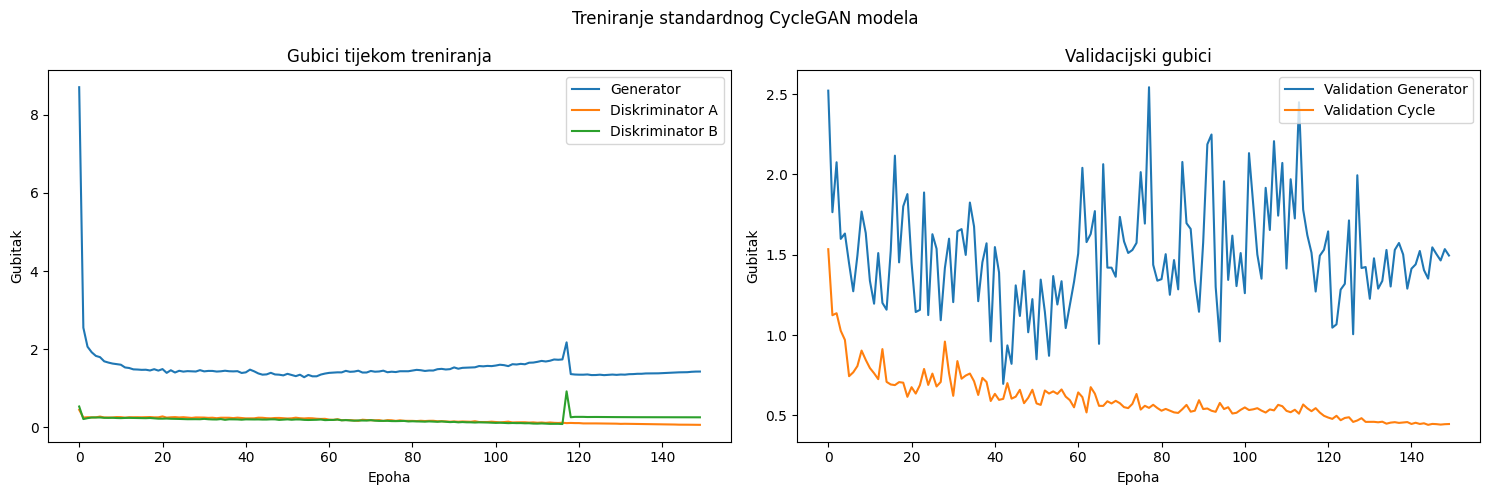

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.83it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8393
  MSE: 0.003398
  PSNR: 25.01 dB

T2 -> T1 translacija:
  SSIM: 0.8619
  MSE: 0.003428
  PSNR: 24.96 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9627
  MSE: 0.000579
  PSNR: 32.57 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9461
  MSE: 0.000915
  PSNR: 30.54 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7474
  MSE: 0.005612
  PSNR: 22.84 dB

T2 -> T1 translacija:
  SSIM: 0.7831
  MSE: 0.005660
  PSNR: 22.79 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9396
  MSE: 0.000956
  PSNR: 30.39 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9100
  MSE: 0.001512
  PSNR: 28.36 dB


Vizualizacija rezultata na test setu:


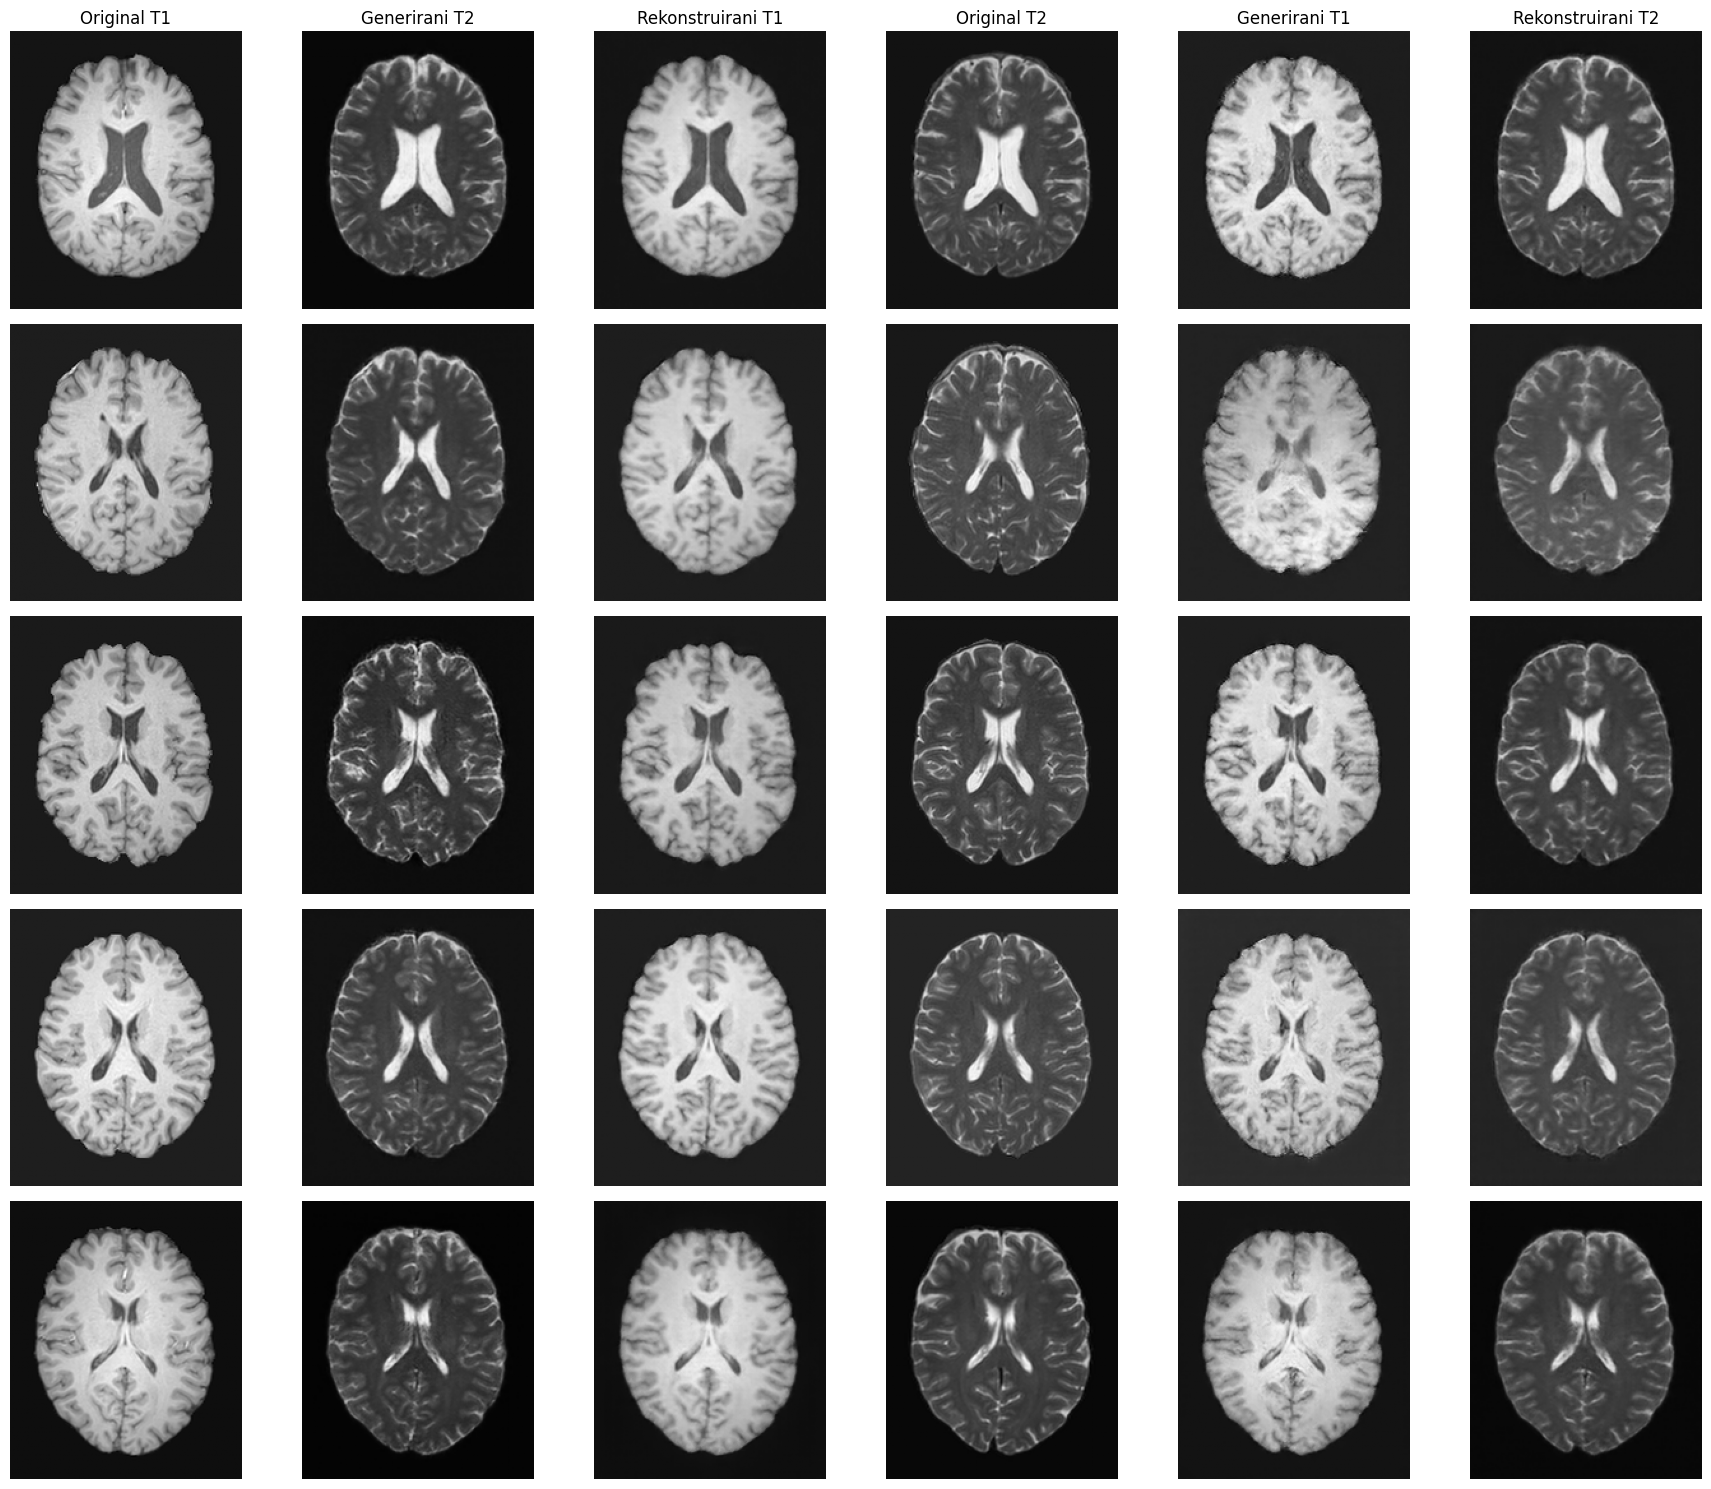

In [11]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=5, config=config)

In [13]:
best_G_AB_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [ ]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)<

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8387
  MSE: 0.003424
  PSNR: 24.98 dB

T2 -> T1 translacija:
  SSIM: 0.8655
  MSE: 0.003400
  PSNR: 25.01 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9634
  MSE: 0.000579
  PSNR: 32.56 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9463
  MSE: 0.000922
  PSNR: 30.52 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7465
  MSE: 0.005655
  PSNR: 22.80 dB

T2 -> T1 translacija:
  SSIM: 0.7851
  MSE: 0.005615
  PSNR: 22.83 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9394
  MSE: 0.000956
  PSNR: 30.38 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9103
  MSE: 0.001523
  PSNR: 28.34 dB


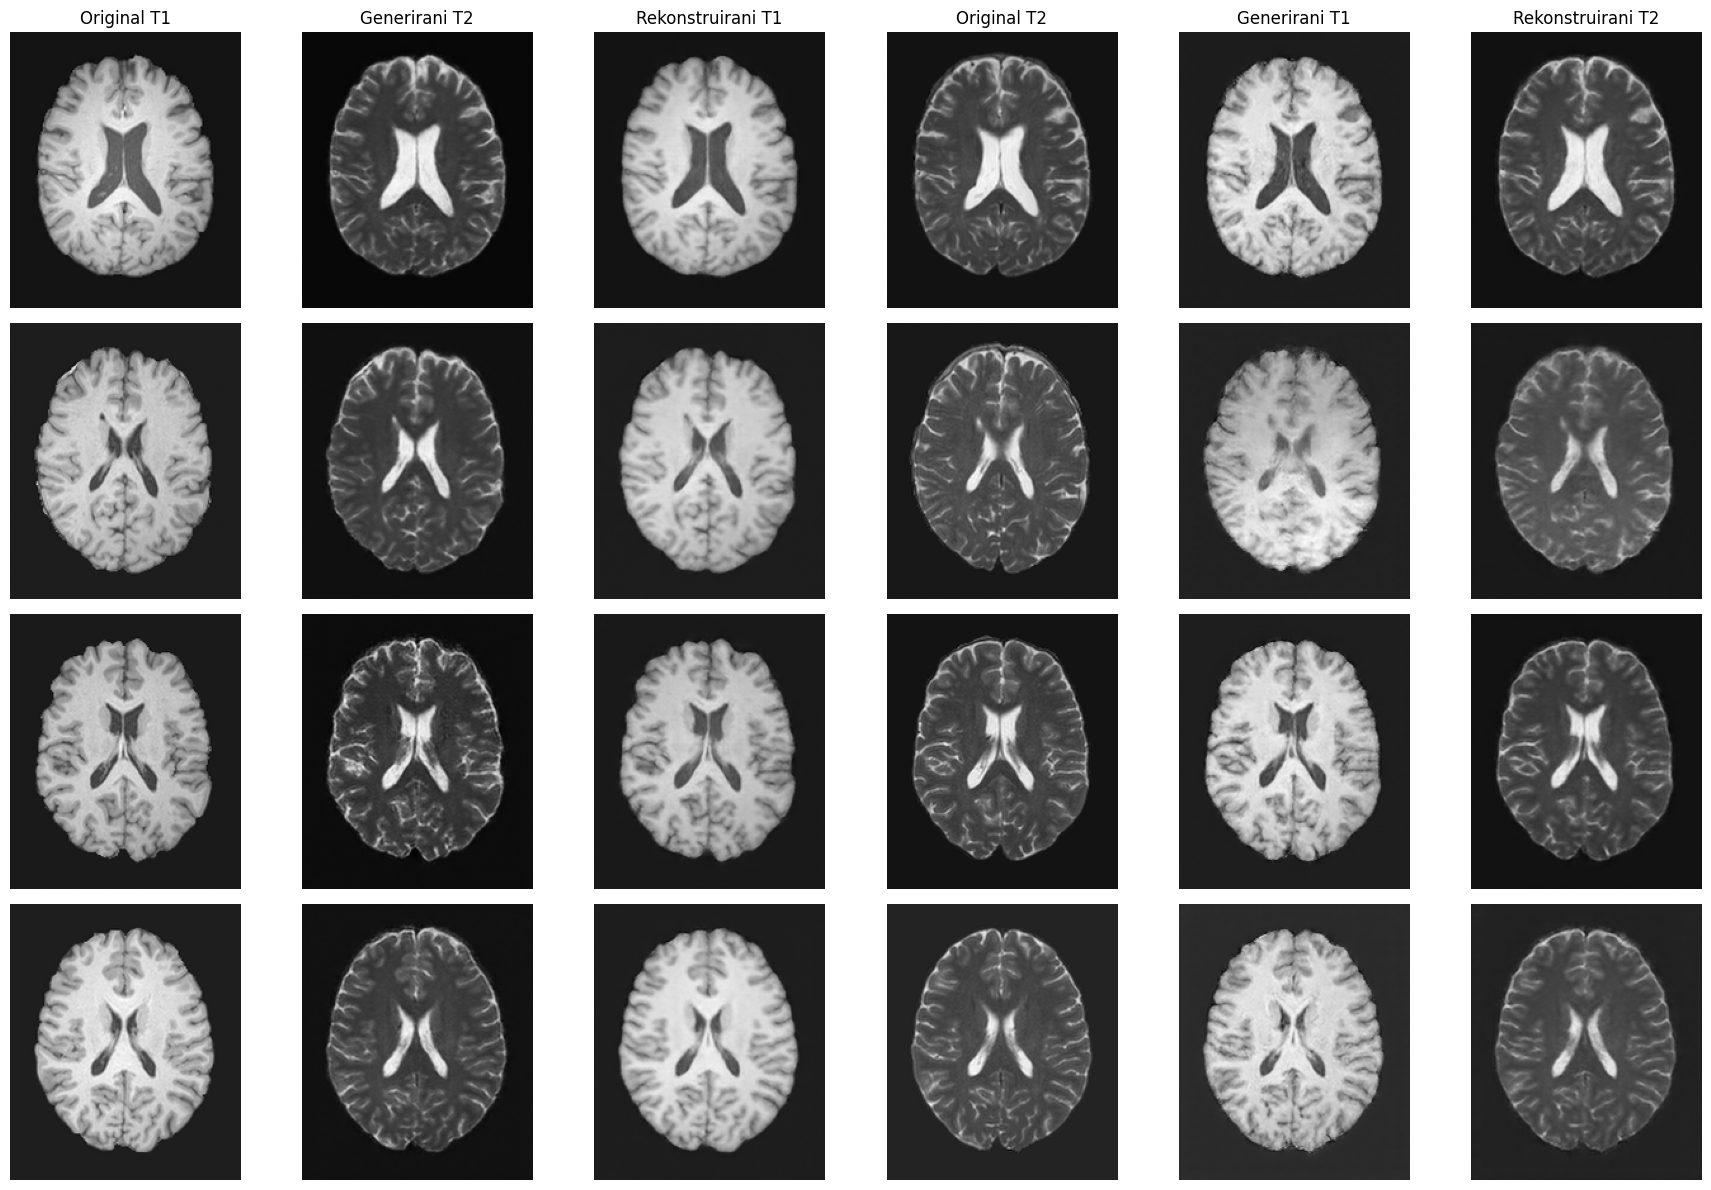

In [15]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=4, config=config
)

In [16]:
best_G_AB_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [17]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7809
  MSE: 0.007103
  PSNR: 21.87 dB

T2 -> T1 translacija:
  SSIM: 0.8022
  MSE: 0.005916
  PSNR: 22.52 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9430
  MSE: 0.000874
  PSNR: 30.75 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9288
  MSE: 0.001813
  PSNR: 27.71 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6510
  MSE: 0.011732
  PSNR: 19.69 dB

T2 -> T1 translacija:
  SSIM: 0.6791
  MSE: 0.009772
  PSNR: 20.34 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9050
  MSE: 0.001443
  PSNR: 28.58 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8819
  MSE: 0.002995
  PSNR: 25.53 dB
